# Gradient Descent Optimizers

@[Chaoming Wang](https://github.com/chaoming0625)
@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

Gradient descent is one of the most popular optimization methods. At present, gradient descent optimizers, combined with the loss function, are the key to machine learning, especially deep learning. In this section, we are going to understand:

- how to use optimizers in BrainPy?
- how to customize your own optimizer?

In [4]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')
bp.__version__

'2.4.3.post3'

In [5]:
import matplotlib.pyplot as plt

## Optimizers in BrainPy

The basic optimizer class in BrainPy is `brainpy.optimizers.optimizer`, which inludes the following optimizers:

- SGD
- Momentum
- Nesterov momentum
- Adagrad
- Adadelta
- RMSProp
- Adam
- LARS
- Adan
- AdamW

All supported optimizers can be inspected through the [brainpy.math.optimizers APIs](../apis/auto/optimizers.rst).

Generally, an optimizer initialization receives the learning rate ``lr``, the trainable variables ``train_vars``, and other hyperparameters for the specific optimizer.  

- ``lr`` can be an instance of float,``bm.Variable`` or ``brainpy.optim.scheduler``. However, whether it's an instance of float or ``bm.Variable``, it will be transformed to be an instance of ``brainpy.optim.Constant`` automatically, which is a class of scheduler. Therefore, the users have to  understand the type of ``lr`` is actually scheduler.
- ``train_vars`` should be a dict of Variable.

Here we launch a SGD optimizer.

In [6]:
a = bm.Variable(bm.ones((5, 4)))
b = bm.Variable(bm.zeros((3, 3)))

op = bp.optim.SGD(lr=0.001, train_vars={'a': a, 'b': b})

When you try to update the parameters, you must provide the corresponding gradients for each parameter in the ``update()`` method. 

In [7]:
op.update({'a': bm.random.random(a.shape), 'b': bm.random.random(b.shape)})

print('a:', a)
print('b:', b)

a: Variable(value=Array([[0.9992506 , 0.9993942 , 0.99941486, 0.99976164],
                      [0.9994534 , 0.99937356, 0.9997609 , 0.999758  ],
                      [0.99927807, 0.99931985, 0.9990735 , 0.99940985],
                      [0.9995624 , 0.99956965, 0.9993627 , 0.9996619 ],
                      [0.9993749 , 0.99997044, 0.9996968 , 0.9990379 ]]),
         dtype=float32)
b: Variable(value=Array([[-0.00015692, -0.00087128, -0.00043575],
                      [-0.00018907, -0.00041636, -0.00086603],
                      [-0.00098443, -0.00046647, -0.00089446]]),
         dtype=float32)


You can process the gradients before applying them. For example, we clip the graidents by the maximum L2-norm. 

In [8]:
grads_pre = {'a': bm.random.random(a.shape), 'b': bm.random.random(b.shape)}

grads_pre

{'a': Array(value=Array([[0.66082776, 0.4898498 , 0.3027234 , 0.52351713],
                    [0.0759604 , 0.4557693 , 0.58292365, 0.7218747 ],
                    [0.6424562 , 0.33066738, 0.39118993, 0.5811727 ],
                    [0.68779147, 0.6951357 , 0.62348413, 0.27283204],
                    [0.5947813 , 0.9510231 , 0.2681589 , 0.10165596]]),
       dtype=float32),
 'b': Array(value=Array([[0.26415503, 0.11564147, 0.08266389],
                    [0.25973928, 0.8325161 , 0.47534716],
                    [0.911289  , 0.79422164, 0.85347724]]),
       dtype=float32)}

In [9]:
grads_post = bm.clip_by_norm(grads_pre, 1.)

grads_post

{'a': Array(value=Array([[0.27230015, 0.20184712, 0.12473997, 0.21572004],
                    [0.03130018, 0.18780394, 0.24019904, 0.2974551 ],
                    [0.26472998, 0.13625453, 0.16119342, 0.23947756],
                    [0.2834108 , 0.28643706, 0.25691238, 0.11242295],
                    [0.24508509, 0.39187783, 0.11049735, 0.04188827]]),
       dtype=float32),
 'b': Array(value=Array([[0.14616422, 0.06398761, 0.0457402 ],
                    [0.14372088, 0.460654  , 0.26302263],
                    [0.5042412 , 0.43946463, 0.4722524 ]]),
       dtype=float32)}

In [10]:
op.update(grads_post)

print('a:', a)
print('b:', b)

a: Variable(value=Array([[0.9989783 , 0.99919236, 0.9992901 , 0.99954593],
                      [0.99942213, 0.99918574, 0.9995207 , 0.9994606 ],
                      [0.99901336, 0.9991836 , 0.99891233, 0.99917036],
                      [0.99927896, 0.9992832 , 0.9991058 , 0.9995495 ],
                      [0.99912983, 0.99957854, 0.9995863 , 0.998996  ]]),
         dtype=float32)
b: Variable(value=Array([[-0.00030309, -0.00093527, -0.00048149],
                      [-0.00033279, -0.00087701, -0.00112905],
                      [-0.00148868, -0.00090593, -0.00136672]]),
         dtype=float32)


```{note}
Optimizer usually has their own dynamically changed variables. If you JIT a function whose logic contains optimizer update, your ``dyn_vars`` in ``bm.jit()`` should include variables in ``Optimzier.vars()``.
```

In [11]:
op.vars()  # SGD optimzier only has an iterable `step` variable to record the training step

{'Constant1.last_epoch': Variable(value=Array(-1), dtype=int32)}

In [12]:
bp.optim.Momentum(lr=0.001, train_vars={'a': a, 'b': b}).vars()  # Momentum has velocity variables

{'Momentum0.a_v': Variable(value=Array([[0., 0., 0., 0.],
                       [0., 0., 0., 0.],
                       [0., 0., 0., 0.],
                       [0., 0., 0., 0.],
                       [0., 0., 0., 0.]]),
          dtype=float32),
 'Momentum0.b_v': Variable(value=Array([[0., 0., 0.],
                       [0., 0., 0.],
                       [0., 0., 0.]]),
          dtype=float32),
 'Constant2.last_epoch': Variable(value=Array(-1), dtype=int32)}

In [13]:
bp.optim.Adam(lr=0.001, train_vars={'a': a, 'b': b}).vars()  # Adam has more variables

{'Adam1.a_m': Variable(value=Array([[0., 0., 0., 0.],
                       [0., 0., 0., 0.],
                       [0., 0., 0., 0.],
                       [0., 0., 0., 0.],
                       [0., 0., 0., 0.]]),
          dtype=float32),
 'Adam1.b_m': Variable(value=Array([[0., 0., 0.],
                       [0., 0., 0.],
                       [0., 0., 0.]]),
          dtype=float32),
 'Adam1.a_v': Variable(value=Array([[0., 0., 0., 0.],
                       [0., 0., 0., 0.],
                       [0., 0., 0., 0.],
                       [0., 0., 0., 0.],
                       [0., 0., 0., 0.]]),
          dtype=float32),
 'Adam1.b_v': Variable(value=Array([[0., 0., 0.],
                       [0., 0., 0.],
                       [0., 0., 0.]]),
          dtype=float32),
 'Constant3.last_epoch': Variable(value=Array(-1), dtype=int32)}

BrainPy also supports learning rate modification of optimizer. For example, an optimizer ``opt = bp.optim.Adam(lr=0.1)`` is created, we want to change the value ``lr=0.1`` into ``lr=0.01``, we can use ``opt.lr.lr=0.01`` or ``opt.lr.set_value(0.01)`` to achieve the goal.
Here is a complete example.

In [14]:
import brainpy as bp
import brainpy.math as bm

dt = 0.04
num_step = int(1.0 / dt)
num_batch = 128

@bm.jit
def build_inputs_and_targets(mean=0.025, scale=0.01):
  sample = bm.random.normal(size=(num_batch, 1, 1))
  bias = mean * 2.0 * (sample - 0.5)
  samples = bm.random.normal(size=(num_batch, num_step, 1))
  noise_t = scale / dt ** 0.5 * samples
  inputs = bias + noise_t
  targets = bm.cumsum(inputs, axis=1)
  return inputs, targets

def train_data():
  for _ in range(100):
    yield build_inputs_and_targets()

class RNN(bp.DynamicalSystem):
  def __init__(self, num_in, num_hidden):
    super(RNN, self).__init__()
    self.rnn = bp.dnn.RNNCell(num_in, num_hidden, train_state=True)
    self.out = bp.dnn.Dense(num_hidden, 1)

  def update(self, x):
    return self.out(self.rnn(x))

with bm.training_environment():
    model = RNN(1, 100)

def loss(predictions, targets, l2_reg=2e-4):
    mse = bp.losses.mean_squared_error(predictions, targets)
    l2 = l2_reg * bp.losses.l2_norm(model.train_vars().unique().dict()) ** 2
    return mse + l2

opt = bp.optim.Adam(lr=0.1)
trainer = bp.BPTT(model, loss_fun=loss, optimizer=opt)
opt.lr.lr=0.01        #Modify the learning rate. You can alse use "opt.lr.set_value(0.01)"
trainer.fit(train_data, num_epoch=10)

Train 0 epoch, use 1.9907 s, loss 3.700279474258423
Train 1 epoch, use 0.7552 s, loss 0.4165635406970978
Train 2 epoch, use 0.7502 s, loss 0.07042382657527924
Train 3 epoch, use 0.7532 s, loss 0.0405302420258522
Train 4 epoch, use 0.7542 s, loss 0.027395188808441162
Train 5 epoch, use 0.7532 s, loss 0.020286478102207184
Train 6 epoch, use 0.7502 s, loss 0.01792110502719879
Train 7 epoch, use 0.7502 s, loss 0.017182694748044014
Train 8 epoch, use 0.7542 s, loss 0.016804635524749756
Train 9 epoch, use 0.7602 s, loss 0.016514629125595093


## Creating A Self-Customized Optimizer

To create your own optimization algorithm, simply inherit from ``bp.optim.Optimizer`` class and override the following methods:

- ``__init__()``: init function that receives the learning rate (``lr``) and trainable variables (``train_vars``). Do not forget to register your dynamical changed variables into ``implicit_vars``. 
- ``update(grads)``: update function that computes the updated parameters. 

The general structure is shown below:

In [15]:
class CustomizeOp(bp.optim.Optimizer):
    def __init__(self, lr, train_vars, *params, **other_params):
        super(CustomizeOp, self).__init__(lr, train_vars)
        
        # customize your initialization
        
    def update(self, grads):
        # customize your update logic
        pass

## Schedulers

Scheduler seeks to adjust the learning rate during training through reducing the learning rate according to a pre-defined schedule.  Common learning rate schedules include time-based decay, step decay and exponential decay. 

Here we set up an exponential decay scheduler, in which the learning rate will decay exponentially along the training step.

In [17]:
sc = bp.optim.ExponentialDecayLR(lr=0.1, decay_steps=2, decay_rate=0.99)

In [18]:
def show(steps, rates):
    plt.plot(steps, rates)
    plt.xlabel('Train Step')
    plt.ylabel('Learning Rate')
    plt.show()

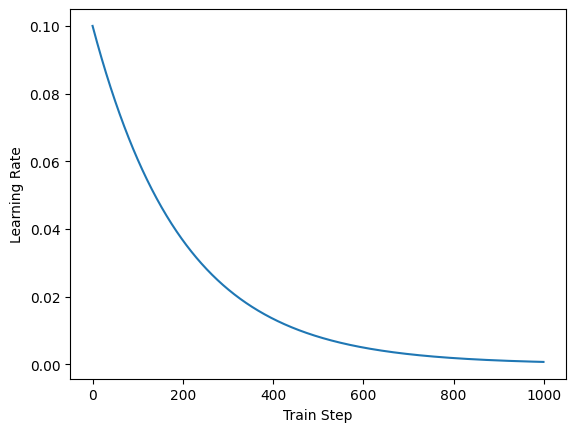

In [19]:
steps = bm.arange(1000)
rates = sc(steps)

show(steps, rates)

After Optimizer initialization, the learning rate ``self.lr`` will always be an instance of ``bm.optimizers.Scheduler``. A scalar float learning rate initialization will result in a ``Constant`` scheduler. 

In [20]:
op.lr

Constant(lr=0.001, last_epoch=-1)

One can get the current learning rate value by calling ``Scheduler.__call__(i=None)``.

- If `i` is not provided, the learning rate value will be evaluated at the built-in training ``step``.
- Otherwise, the learning rate value will be evaluated at the given step ``i``. 

In [21]:
op.lr()

0.001

In BrainPy, several commonly used learning rate schedulers are used:

- Constant
- StepLR
- MultiStepLR
- CosineAnnealingLR
- ExponentialLR
- ExponentialDecayLR
- InverseTimeDecayLR
- PolynomialDecayLR
- PiecewiseConstantLR
- CosineAnnealingWarmRestarts

For more details, please see the [brainpy.math.optimizers APIs](../apis/auto/math/optimizers.rst). 


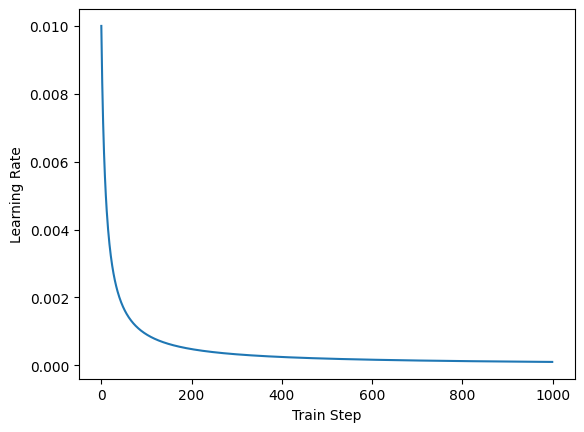

In [22]:
# InverseTimeDecay scheduler

rates = bp.optim.InverseTimeDecayLR(lr=0.01, decay_steps=10, decay_rate=0.999)(steps)
show(steps, rates)

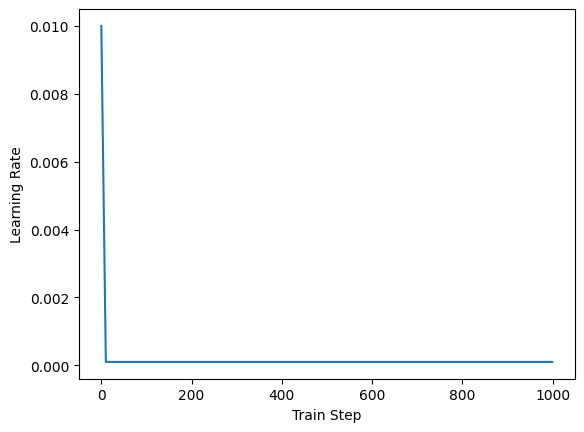

In [23]:
# PolynomialDecay scheduler

rates = bp.optim.PolynomialDecayLR(lr=0.01, decay_steps=10, final_lr=0.0001)(steps)
show(steps, rates)

## Creating a Self-Customized Scheduler

If users try to implement their own scheduler, simply inherit from ``bm.optimizers.Scheduler`` class and override the following methods:

- ``__init__()``: the init function. 
- ``__call__(i=None)``: the learning rate value evalution. 

In [24]:
class CustomizeScheduler(bp.optim.Scheduler):
    def __init__(self, lr, *params, **other_params):
        super(CustomizeScheduler, self).__init__(lr)
        
        # customize your initialization
        
    def __call__(self, i=None):
        # customize your update logic
        pass